In [1]:
import os
import cv2
import numpy as np

# Directory containing face images
faces_dir = "dataset/faces/"
face_images = []
face_labels = []
label = 0
h, w = 64, 64  # Set the desired height and width for the images

for person_name in os.listdir(faces_dir):
    person_dir = os.path.join(faces_dir, person_name)
    if not os.path.isdir(person_dir):
        continue
    for image_name in os.listdir(person_dir):
        img_path = os.path.join(person_dir, image_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Failed to load {img_path}")
            continue
        resized_img = cv2.resize(img, (h, w))  # Resize to fixed size
        face_images.append(resized_img.flatten())
        face_labels.append(label)
    label += 1

# Convert lists to numpy arrays
X = np.array(face_images)
y = np.array(face_labels)

print(f"Face database shape: {X.shape}, Labels: {y.shape}")


Face database shape: (450, 4096), Labels: (450,)


In [2]:
mean_face = np.mean(X, axis=0)



In [3]:
X_mean_zero = X - mean_face


In [4]:
# Using surrogate covariance matrix
C = np.dot(X_mean_zero, X_mean_zero.T)


In [5]:
eigvals, eigvecs = np.linalg.eigh(C)


In [6]:
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

# Select top k eigenvectors
k = 100  # Example value, you can vary this
top_k_eigenvectors = eigvecs[:, :k]


In [7]:
eigenfaces = np.dot(X_mean_zero.T, top_k_eigenvectors)
eigenfaces = eigenfaces / np.linalg.norm(eigenfaces, axis=0)


In [8]:
face_signatures = np.dot(X_mean_zero, eigenfaces)



In [9]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Split the data
X_train, X_test, y_train, y_test = train_test_split(face_signatures, y, test_size=0.4, random_state=42)

# Train ANN model
ann_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
ann_model.fit(X_train, y_train)

# Evaluate the model
y_pred = ann_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification accuracy: {accuracy}")


Classification accuracy: 0.4777777777777778


In [10]:
imposters_dir = "dataset/imposters/"
X_imposters = []
imposter_labels = []

for imposter_name in os.listdir(imposters_dir):
    imposter_path = os.path.join(imposters_dir, imposter_name)
    img = cv2.imread(imposter_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load {imposter_path}")
        continue
    resized_img = cv2.resize(img, (h, w))
    X_imposters.append(resized_img.flatten())
    imposter_labels.append(-1)  # Unique label for imposters

# Convert lists to numpy arrays
X_imposters = np.array(X_imposters)
imposter_labels = np.array(imposter_labels)

print("Number of imposter images loaded:", len(X_imposters))


Number of imposter images loaded: 270


In [11]:
X_imposters_mean_zero = X_imposters - mean_face
imposter_signatures = np.dot(X_imposters_mean_zero, eigenfaces)


In [12]:
X_test_combined = np.vstack((X_test, imposter_signatures))
y_test_combined = np.concatenate((y_test, imposter_labels))

print("Shape of combined_face_signatures:", X_test_combined.shape)  # Debug print

# Use trained ANN model for prediction
y_pred_combined = ann_model.predict(X_test_combined)

# Evaluate predictions
for i, pred_label in enumerate(y_pred_combined):
    if pred_label == -1:
        print(f"Test image {i} is classified as an imposter.")
    else:
        print(f"Test image {i} is classified as person {pred_label}.")


Shape of combined_face_signatures: (450, 100)
Test image 0 is classified as person 6.
Test image 1 is classified as person 1.
Test image 2 is classified as person 5.
Test image 3 is classified as person 3.
Test image 4 is classified as person 8.
Test image 5 is classified as person 6.
Test image 6 is classified as person 3.
Test image 7 is classified as person 6.
Test image 8 is classified as person 5.
Test image 9 is classified as person 5.
Test image 10 is classified as person 2.
Test image 11 is classified as person 7.
Test image 12 is classified as person 1.
Test image 13 is classified as person 2.
Test image 14 is classified as person 6.
Test image 15 is classified as person 2.
Test image 16 is classified as person 4.
Test image 17 is classified as person 1.
Test image 18 is classified as person 1.
Test image 19 is classified as person 1.
Test image 20 is classified as person 1.
Test image 21 is classified as person 0.
Test image 22 is classified as person 6.
Test image 23 is clas

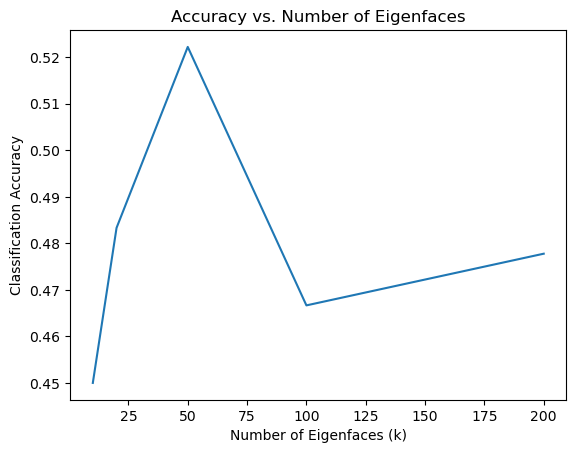

In [13]:
import matplotlib.pyplot as plt

k_values = [10, 20, 50, 100, 200]
accuracies = []

for k in k_values:
    top_k_eigenvectors = eigvecs[:, :k]
    eigenfaces = np.dot(X_mean_zero.T, top_k_eigenvectors)
    eigenfaces = eigenfaces / np.linalg.norm(eigenfaces, axis=0)
    face_signatures = np.dot(X_mean_zero, eigenfaces)
    X_train, X_test, y_train, y_test = train_test_split(face_signatures, y, test_size=0.4, random_state=42)
    ann_model.fit(X_train, y_train)
    y_pred = ann_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

plt.plot(k_values, accuracies)
plt.xlabel('Number of Eigenfaces (k)')
plt.ylabel('Classification Accuracy')
plt.title('Accuracy vs. Number of Eigenfaces')
plt.show()


In [14]:
#example

Classification accuracy for k=10: 0.42777777777777776
Classification accuracy for k=20: 0.5277777777777778
Classification accuracy for k=30: 0.45555555555555555
Classification accuracy for k=40: 0.4444444444444444
Classification accuracy for k=50: 0.43333333333333335
Classification accuracy for k=60: 0.4777777777777778
Classification accuracy for k=70: 0.48333333333333334
Classification accuracy for k=80: 0.43333333333333335
Classification accuracy for k=90: 0.5111111111111111
Classification accuracy for k=100: 0.43333333333333335
Classification accuracy for k=110: 0.4388888888888889
Classification accuracy for k=120: 0.45
Classification accuracy for k=130: 0.4388888888888889
Classification accuracy for k=140: 0.3888888888888889
Classification accuracy for k=150: 0.4222222222222222
Classification accuracy for k=160: 0.5055555555555555
Classification accuracy for k=170: 0.42777777777777776
Classification accuracy for k=180: 0.43333333333333335
Classification accuracy for k=190: 0.466666

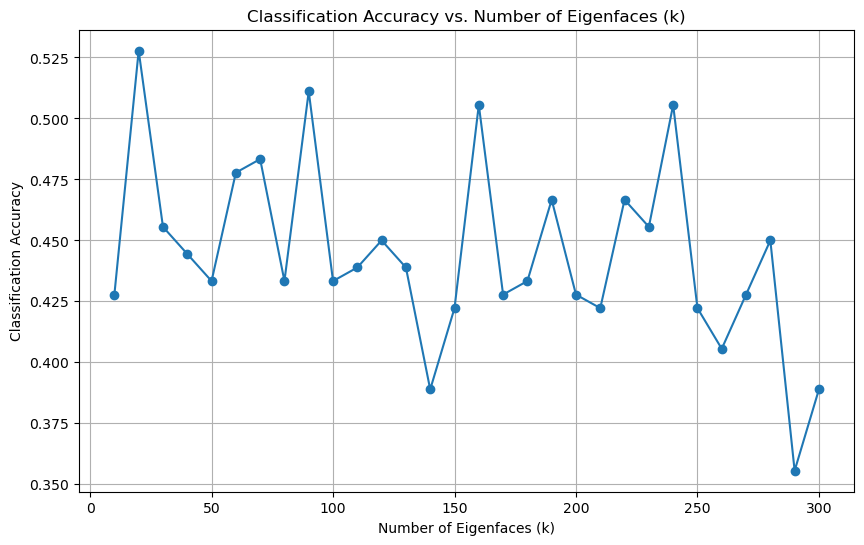

In [15]:
#a) Change the value of k and then, see how it changes the classification accuracy. Plot a 
#graph between accuracy and k value to show the comparative study
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Set the desired height and width for the images
h, w = 64, 64

# Directory containing face images
faces_dir = "dataset/faces/"
face_images = []
face_labels = []
label = 0

for person_name in os.listdir(faces_dir):
    person_dir = os.path.join(faces_dir, person_name)
    if not os.path.isdir(person_dir):
        continue
    for image_name in os.listdir(person_dir):
        img_path = os.path.join(person_dir, image_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Failed to load {img_path}")
            continue
        resized_img = cv2.resize(img, (h, w))  # Resize to fixed size
        face_images.append(resized_img.flatten())
        face_labels.append(label)
    label += 1

# Convert lists to numpy arrays
X = np.array(face_images)
y = np.array(face_labels)

# Calculate the mean face
mean_face = np.mean(X, axis=0)

# Do mean zero
X_mean_zero = X - mean_face

# Using surrogate covariance matrix
C = np.dot(X_mean_zero, X_mean_zero.T)

# Eigenvalue and eigenvector decomposition
eigvals, eigvecs = np.linalg.eigh(C)

# Sort eigenvalues and eigenvectors
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

# Values of k to evaluate
k_values = range(10, 310, 10)
accuracies = []

for k in k_values:
    # Select top k eigenvectors
    top_k_eigenvectors = eigvecs[:, :k]

    # Generate eigenfaces
    eigenfaces = np.dot(X_mean_zero.T, top_k_eigenvectors)
    eigenfaces = eigenfaces / np.linalg.norm(eigenfaces, axis=0)

    # Generate signature of each face
    face_signatures = np.dot(X_mean_zero, eigenfaces)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(face_signatures, y, test_size=0.4, random_state=42)

    # Train ANN model
    ann_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
    ann_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = ann_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Classification accuracy for k={k}: {accuracy}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.title('Classification Accuracy vs. Number of Eigenfaces (k)')
plt.xlabel('Number of Eigenfaces (k)')
plt.ylabel('Classification Accuracy')
plt.grid(True)
plt.show()


Classification accuracy for k=10: 0.16666666666666666
Confusion Matrix:
[[  0  26  22  20  28   2 105  51  14   2]
 [  0   7   4   5   1   0   3   2   1   1]
 [  0   6  11   4   0   0   0   0   0   0]
 [  0   2   2   8   3   2   1   2   1   0]
 [  0   1   0   5   4   0   1   2   0   5]
 [  0   2   0   0   0  14   0   0   0   0]
 [  0   2   0   2   4   0   6   1   2   0]
 [  0   1   0   0   0   1   4   3   0   6]
 [  0   1   1   2   0   4   0   1  15   0]
 [  0   2   1   2   7   0   2   1   2   7]]
Classification accuracy for k=20: 0.19111111111111112
Confusion Matrix:
[[ 0 24 17 39  5  2 48 69 66  0]
 [ 0  9  7  0  2  2  1  2  1  0]
 [ 0  4 16  0  0  0  1  0  0  0]
 [ 0  0  3 11  0  1  4  0  2  0]
 [ 0  1  1  2  3  1  2  4  0  4]
 [ 0  2  0  0  0 14  0  0  0  0]
 [ 0  0  1  1  5  1  7  0  0  2]
 [ 0  0  0  2  1  2  2  4  2  2]
 [ 0  2  2  3  0  0  1  0 16  0]
 [ 0  0  0  3  5  2  2  6  0  6]]
Classification accuracy for k=30: 0.19111111111111112
Confusion Matrix:
[[ 0 22 32 64  5 13 48

Classification accuracy for k=200: 0.1711111111111111
Confusion Matrix:
[[ 0 53  7  4  3 72 27  4 86 14]
 [ 0  4  2  2  2  2  2  1  8  1]
 [ 0  0 10  3  0  0  5  0  3  0]
 [ 0  1  1 10  1  0  3  1  4  0]
 [ 0  0  1  2  5  1  0  4  3  2]
 [ 0  0  0  2  0 12  0  0  2  0]
 [ 0  0  0  3  3  0  8  1  0  2]
 [ 0  0  1  2  4  0  0  7  0  1]
 [ 0  2  1  1  0  5  2  0 13  0]
 [ 0  1  0  5  4  0  0  1  5  8]]
Classification accuracy for k=210: 0.16
Confusion Matrix:
[[  0  23  10  25   1  43  26   4 124  14]
 [  0   5   4   9   1   1   1   1   2   0]
 [  0   1  14   3   0   1   0   0   0   2]
 [  0   0   2   9   0   1   4   2   2   1]
 [  0   0   0   0   7   1   3   3   2   2]
 [  0   0   0   0   0  10   0   0   4   2]
 [  0   0   1   2   3   0   5   4   0   2]
 [  0   0   3   0   4   2   2   3   1   0]
 [  0   1   1   6   0   0   4   2  10   0]
 [  0   1   0   0   4   1   3   5   1   9]]
Classification accuracy for k=220: 0.17555555555555555
Confusion Matrix:
[[ 0 47 12 19  6 54 28  1 34 69]
 [

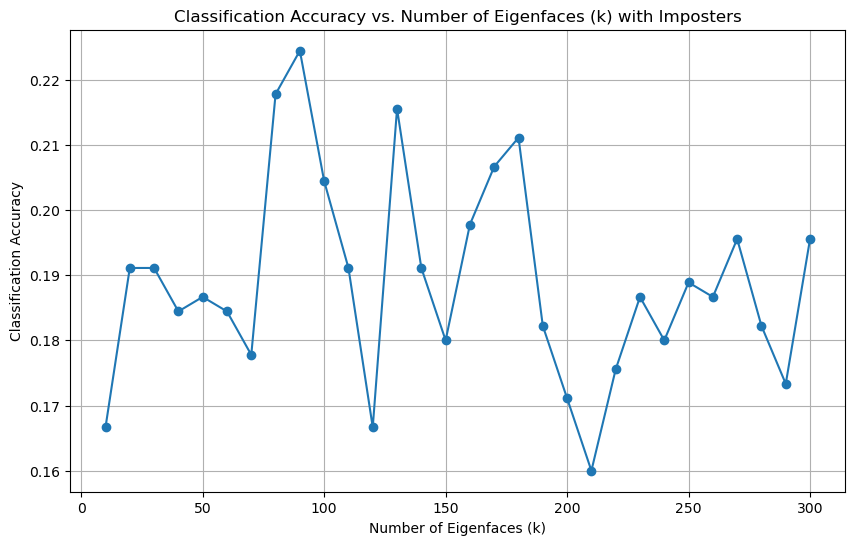

In [22]:
#) b Add imposters (who do not belong to the training set) into the test set and then
#recognize it as the not enrolled person.
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Set the desired height and width for the images
h, w = 64, 64

# Directory containing face images
faces_dir = "dataset/faces/"
imposters_dir = "dataset/imposters/"

face_images = []
face_labels = []
label = 0

# Load face images
for person_name in os.listdir(faces_dir):
    person_dir = os.path.join(faces_dir, person_name)
    if not os.path.isdir(person_dir):
        continue
    for image_name in os.listdir(person_dir):
        img_path = os.path.join(person_dir, image_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Failed to load {img_path}")
            continue
        resized_img = cv2.resize(img, (h, w))  # Resize to fixed size
        face_images.append(resized_img.flatten())
        face_labels.append(label)
    label += 1

# Load imposter images
for imposter_name in os.listdir(imposters_dir):
    imposter_path = os.path.join(imposters_dir, imposter_name)
    img = cv2.imread(imposter_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load {imposter_path}")
        continue
    resized_img = cv2.resize(img, (h, w))  # Resize to fixed size
    face_images.append(resized_img.flatten())
    face_labels.append(-1)  # Unique label for imposters

# Convert lists to numpy arrays
X = np.array(face_images)
y = np.array(face_labels)

# Calculate the mean face
mean_face = np.mean(X, axis=0)

# Do mean zero
X_mean_zero = X - mean_face

# Using surrogate covariance matrix
C = np.dot(X_mean_zero, X_mean_zero.T)

# Eigenvalue and eigenvector decomposition
eigvals, eigvecs = np.linalg.eigh(C)

# Sort eigenvalues and eigenvectors
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

# Values of k to evaluate
k_values = range(10, 310, 10)
accuracies = []

for k in k_values:
    # Select top k eigenvectors
    top_k_eigenvectors = eigvecs[:, :k]

    # Generate eigenfaces
    eigenfaces = np.dot(X_mean_zero.T, top_k_eigenvectors)
    eigenfaces = eigenfaces / np.linalg.norm(eigenfaces, axis=0)

    # Generate signature of each face
    face_signatures = np.dot(X_mean_zero, eigenfaces)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(face_signatures[y != -1], y[y != -1], test_size=0.4, random_state=42)

    # Append imposter data to the test set
    X_test_imposters = face_signatures[y == -1]
    y_test_imposters = y[y == -1]

    X_test_combined = np.vstack((X_test, X_test_imposters))
    y_test_combined = np.concatenate((y_test, y_test_imposters))

    # Train ANN model
    ann_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
    ann_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = ann_model.predict(X_test_combined)
    accuracy = accuracy_score(y_test_combined, y_pred)
    accuracies.append(accuracy)
    print(f"Classification accuracy for k={k}: {accuracy}")

    # Print confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_combined, y_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.title('Classification Accuracy vs. Number of Eigenfaces (k) with Imposters')
plt.xlabel('Number of Eigenfaces (k)')
plt.ylabel('Classification Accuracy')
plt.grid(True)
plt.show()
